<a href="https://colab.research.google.com/github/kevinkhu/exoplanet_atmospheres/blob/main/Exoplanet_Archive_Atmospheric_Forward_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NASA Exoplanet Archive Atmospheric Forward Modeling
This notebook is a tutorial for forward modeling exoplanet atmospheres using the ATMO grid ([Goyal et al., 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.4503G/abstract)) and has been tailored for use with [Transmission Spectroscopy data](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=transitspec) from the Exoplanet Archive.

This notebook is meant to require minimal user input, unless you want to provide your own data. Each step will either begin with *(Play)* or **(Input)**. No editing is necessary for the *(Play)* steps, just hover over the cell and press the "Play" button on the left. The **(Input)** steps will tell you what can be changed.

**NOTE:** This has not been tested on all planets with transmission spectroscopy data on the Exoplanet Archive, so your results may vary!

**Estimated Runtime**: 3 minutes

*Author*: [Kevin Hardegree-Ullman](http://kevinkhu.com)

*Last Modified*: April 14, 2021

1.   *(Play)* Install the [SpectRes](https://spectres.readthedocs.io/en/latest/) spectral resampling package.

In [1]:
!pip install spectres

2.   *(Play)* Import some packages!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spectres as spectres

print('Packages successfully imported!')

Packages successfully imported!


3.   *(Play)* Read in the [transmission spectroscopy table](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=transitspec) from the Exoplanet Archive and list the available planets.

In [3]:
url="https://www.dropbox.com/s/eteod7kpwpd95d8/transitspec_2021.04.08_11.45.14.csv?dl=1"
tstable=pd.read_csv(url, comment='#', header=0)
tstable.dropna(subset=['plnratror','bandwidth','centralwavelng'], inplace=True, axis=0)
tstable.sort_values('plntname',inplace=True)
tstable.reset_index(drop=True,inplace=True)

print('Here are all the available planets: ',tstable.plntname.unique())

Here are all the available planets:  ['55 Cnc e' 'CoRoT-1 b' 'GJ 1132 b' 'GJ 1214 b' 'GJ 3470 b' 'HAT-P-1 b'
 'HAT-P-12 b' 'HAT-P-16 b' 'HAT-P-18 b' 'HAT-P-19 b' 'HAT-P-26 b'
 'HAT-P-3 b' 'HAT-P-32 b' 'HD 189733 b' 'HD 209458 b' 'Qatar-1 b'
 'TRAPPIST-1 g' 'TrES-2 b' 'TrES-3 b' 'TrES-4 b' 'WASP-103 b' 'WASP-12 b'
 'WASP-121 b' 'WASP-127 b' 'WASP-17 b' 'WASP-19 b' 'WASP-21 b' 'WASP-31 b'
 'WASP-33 b' 'WASP-39 b' 'WASP-4 b' 'WASP-43 b' 'WASP-45 b' 'WASP-46 b'
 'WASP-52 b' 'WASP-6 b' 'WASP-67 b' 'WASP-69 b' 'WASP-74 b' 'WASP-80 b'
 'WASP-96 b' 'WASP-98 b' 'XO-2 N b']


4. **(Input)** Select your favorite planet from the list above.

In [4]:
planet = 'WASP-121 b' # Edit the name within the quotes. Make sure the exact string matches a planet in the list above.

if tstable['plntname'].str.contains(planet).any():
  print("You have selected planet "+planet+".")
else:
  print("Please check your planet name, it doesn't appear to be in the list above.")

You have selected planet WASP-121 b.


5. *(Play)* Plot the data! Check that things look okay.

Text(0, 0.5, '$R_p/R_{\\star}$')

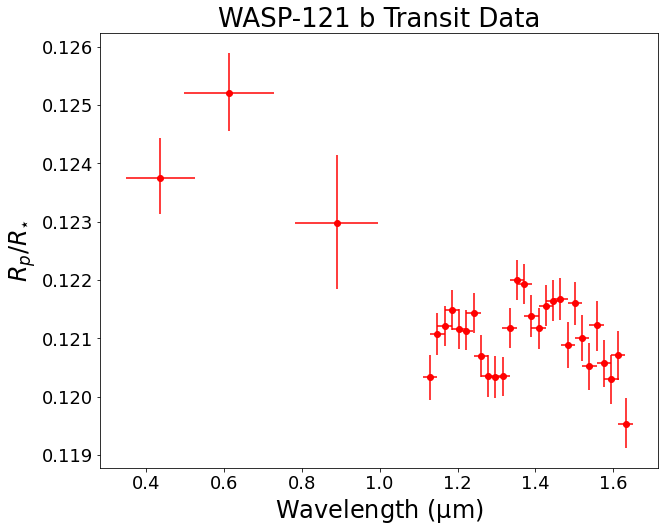

In [5]:
# Extract data from the table above for only the selected planet.
df = tstable.loc[(tstable['plntname'] == planet) & (tstable['centralwavelng'] > 0.3)] #This truncates the data to >0.3 microns, the limit of the models used below.
df = df.dropna(subset=['bandwidth', 'plnratror', 'plnratrorerr1', 'plnratrorerr2'])
df = df.sort_values(by='centralwavelng')
df = df.reset_index(drop=True)

# Make the plot
plt.figure(figsize=(10,8))
plt.title(planet+' Transit Data', fontsize=26)
plt.errorbar(x=df.centralwavelng,y=df.plnratror,xerr=df.bandwidth,yerr=[df.plnratrorerr1,-df.plnratrorerr2],fmt='o',color='red')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Wavelength ($\mathrm{\mu}$m)',fontsize=24)
plt.ylabel('$R_p/R_{\star}$',fontsize=24)

# plt.xscale('log') #uncomment if necessary

6. *(Play)* Download system parameter data from the Exoplanet Archive. 

In [6]:
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=compositepars"
syspars=pd.read_csv(url, comment='#', header=0)
plsyspars = syspars.loc[(syspars['fpl_name'] == planet)]
plsyspars = plsyspars.reset_index(drop=True)
plsyspars

,fpl_hostname,fpl_letter,fpl_name,fpl_discmethod,fpl_disc,fpl_controvflag,fpl_orbper,fpl_orbpererr1,fpl_orbpererr2,fpl_orbperlim,fpl_orbperreflink,fpl_smax,fpl_smaxerr1,fpl_smaxerr2,fpl_smaxlim,fpl_smaxreflink,fpl_eccen,fpl_eccenerr1,fpl_eccenerr2,fpl_eccenlim,fpl_eccenreflink,fpl_bmasse,fpl_bmasseerr1,fpl_bmasseerr2,fpl_bmasselim,fpl_bmassprov,fpl_bmassreflink,fpl_rade,fpl_radeerr1,fpl_radeerr2,fpl_radelim,fpl_radreflink,fpl_dens,fpl_denserr1,fpl_denserr2,fpl_denslim,fpl_densreflink,fpl_eqt,fpl_eqterr1,fpl_eqterr2,...,fst_nirmagreflink,fst_spt,fst_sptlim,fst_sptreflink,fst_teff,fst_tefferr1,fst_tefferr2,fst_tefflim,fst_teffreflink,fst_logg,fst_loggerr1,fst_loggerr2,fst_logglim,fst_loggreflink,fst_lum,fst_lumerr1,fst_lumerr2,fst_lumlim,fst_lumreflink,fst_mass,fst_masserr1,fst_masserr2,fst_masslim,fst_massreflink,fst_rad,fst_raderr1,fst_raderr2,fst_radlim,fst_radreflink,fst_met,fst_meterr1,fst_meterr2,fst_metlim,fst_metratio,fst_metreflink,fst_age,fst_ageerr1,fst_ageerr2,fst_agelim,fst_agereflink
0,WASP-121,b,WASP-121 b,Transit,2016,0,1.274925,2.000000e-07,-2.500000e-07,0.0,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,0.02544,0.00049,-0.0005,0.0,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,0.0,NaN,NaN,0.0,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,375.99289,20.34112,-19.70546,0.0,Mass,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,20.905,0.493,-0.493,0.0,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,0.243,0.021,-0.021,0.0,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,2358.0,52.0,-52.0,...,<a refstr=2MASS_POINT_SOURCE_CATALOG href=http...,F6 V,0.0,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,6459.0,140.0,-140.0,0.0,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,4.24,0.01,-0.01,0.0,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,0.519,0.038,-0.041,0.0,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,1.35,0.08,-0.08,0.0,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,1.46,0.03,-0.03,0.0,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,0.13,0.09,-0.09,0.0,[Fe/H],<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,1.5,1.0,-1.0,0.0,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...


7. *(Play)* Take the basic planet and stellar parameters from the table above. Compute planet surface gravity for use below. Feel free to **(Input)** your own values if you have them.

In [7]:
#Reference quantities
R_earth = 6371009 #meters
R_jup = 69950000 #meters
R_sun = 695700000 #meters
M_earth = 5.97e24 #kilograms
M_jup = 1.898e27 #kilograms
M_sun = 1.988435e30 #kilograms
G = 6.6743015e-11 #m^3 kg^-1 s^-2

#Planet Parameters
R_guess = plsyspars['fpl_rade'][0] * R_earth #Planet radius guess in Earth radii, if that wasn't obvious already
R_err = np.mean([np.abs(plsyspars['fpl_radeerr1'][0]),np.abs(plsyspars['fpl_radeerr2'][0])]) * R_earth #Planet radius error in Earth radii
print('Planet Parameters:')
print('R_planet = '+str(round(R_guess/R_earth,2))+' \u00B1 '+str(round(R_err/R_earth,2))+' R_Earth = '+str(round(R_guess/R_jup,2))+' \u00B1 '+str(round(R_err/R_jup,2))+' R_Jupiter')

M_pl = plsyspars['fpl_bmasse'][0] * M_earth #Planet mass (or msini) in Earth masses
M_pl_err = np.mean([np.abs(plsyspars['fpl_bmasseerr1'][0]),np.abs(plsyspars['fpl_bmasseerr2'][0])]) * M_earth #Planet mass error in Earth masses
print('M_planet = '+str(round(M_pl/M_earth,2))+' \u00B1 '+str(round(M_pl_err/M_earth,2))+' M_Earth = '+str(round(M_pl/M_jup,2))+' \u00B1 '+str(round(M_pl_err/M_jup,2))+' M_Jupiter')

grav = G*M_pl/(R_guess**2)
print('Surface Gravity = '+str(round(grav,2))+' m/s^2')

T_guess = plsyspars['fpl_eqt'][0] #Planet equilibrium temperature guess in Kelvin
print('T_eq = '+str(int(T_guess))+' K')

#Stellar Host Parameters
Rs = plsyspars['fst_rad'][0] * R_sun #Star radius in Sun radii
Rs_err = np.mean([np.abs(plsyspars['fst_raderr1'][0]),np.abs(plsyspars['fst_raderr2'][0])]) * R_sun #Star radius measurement error in Sun radii
print('\nStellar Host Parameters')
print('R_star = '+str(round(Rs/R_sun,2))+' \u00B1 '+str(round(Rs_err/R_sun,2))+' R_Sun')

T_star = plsyspars['fst_teff'][0] #Star effective temperature in Kelvin
print('T_eff = '+str(int(T_star))+' K')

Planet Parameters:
R_planet = 20.9 ± 0.49 R_Earth = 1.9 ± 0.04 R_Jupiter
M_planet = 375.99 ± 20.02 M_Earth = 1.18 ± 0.06 M_Jupiter
Surface Gravity = 8.45 m/s^2
T_eq = 2358 K

Stellar Host Parameters
R_star = 1.46 ± 0.03 R_Sun
T_eff = 6459 K


8. *(Play)* Download [ATMO](https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.4503G/abstract) models closest to the surface gravity and equilibrium temperatures in Step 7. Please be patient, this will take a couple of minutes.

In [8]:
#Find closest matching surface gravity and 4 closest equilibrium temperatures that have models.
modgravarr = [5,10,20,50]
mod = np.abs(modgravarr - grav).tolist()
modgrav = modgravarr[mod.index(min(mod))]
teqlist = [int(np.floor(T_guess/100))*100-100,int(np.floor(T_guess/100))*100,int(np.ceil(T_guess/100))*100,int(np.ceil(T_guess/100))*100+100]
print('Downloading models for g = '+str(modgrav)+' m/s^2 and T_eq = '+str(teqlist[0])+', '+str(teqlist[1])+', '+str(teqlist[2])+', and '+str(teqlist[3])+' K')

#Download ATMO models and combine into a single mega grid. This will take a couple minutes.
x=0
for i in teqlist:
  url = 'http://kevinkhu.com/goyalmodels/'+str(modgrav).zfill(2)+'/'+str(i).zfill(4)+'_'+str(modgrav).zfill(2)+'.csv'
  if x == 0:
    model = pd.read_csv(url,header=0)
  else:
    model2 = pd.read_csv(url,header=0)
    model = model.merge(model2,on='wavelength')
  x=1
print('ATMO model download complete!')

ATMO model download complete!


9. *(Play)* Find the three ATMO models that fit the data best. Please see [Goyal et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.4503G/abstract) for a description of the model parameters.

In [9]:
#Identify a normalization index for data and models
df.loc[df['plnratror']==df['plnratror'].median()]
normidx = df.loc[df['plnratror']==df['plnratror'].mean()]
try:
  ni = normidx.index.tolist()[0]
except:
  ni = int(len(df)/2)

#Compute (Rp/Rs)^2 and associated errors
df['rprs2'] = (df['plnratror']**2)/(np.array(df['plnratror'][ni])**2)
df['rprs2_err'] = 2*(np.mean([np.abs(df['plnratrorerr1']),np.abs(df['plnratrorerr2'])])/df['plnratror'])*df['rprs2']

#Truncate dataframe to values we care about
dfsm = df[['centralwavelng','bandwidth','rprs2','rprs2_err']].copy()

#Resample high-resolution models to the wavelength scale of the data
columns = list(model)
for i in columns:
  f = spectres.spectres(np.array(df.centralwavelng),np.array(model.wavelength),np.array(model[i]), spec_errs=None)
  dfsm[i] = f/f[ni]

dft = dfsm[['centralwavelng','bandwidth','rprs2','rprs2_err','wavelength']].copy()
dfm = dfsm.drop(['centralwavelng','bandwidth','rprs2','rprs2_err','wavelength'],axis=1)

#Compute the goodness-of-fit statistic (G_k) (Eq. 1 of Cushing et al. (2008)), which is effectively a chi-squared minimization, to identify the best fitting model
fmean = np.mean(dft.rprs2)
dfmn = dfm.div(dfm.mean(axis=0),axis=1)
dfmn = dfmn.multiply(fmean,axis=0)
dfs = dfmn.sub(dft['rprs2'],axis=0)
dfs = dfs.div(dft['rprs2_err'],axis=0)
dfp = np.power(dfs,2)
dfp.loc['Total']=dfp.sum()

#Find the 3 best fitting models!
min1 = dfp.loc['Total'].idxmin(axis=1)
dft['best'] = dfmn[min1]
dft['residual'] = (dft.rprs2 - dft.best)/dft.rprs2
dfx = dfp.drop(columns=[min1])
min2 = dfx.loc['Total'].idxmin(axis=1)
dfx = dfx.drop(columns=[min2])
min3 = dfx.loc['Total'].idxmin(axis=1)
print(planet+' best fitting forward models:')
print('(1) T_eq = '+min1[0:4].lstrip('0')+' K, g = '+min1[5:7]+' m/s^2, log(metallicity_atmo) = '+min1[8:12]+', C/O = '+min1[13:17]+', Haze = '+min1[18:22].lstrip('0')+', Cloud = '+min1[23:27])
print('(2) T_eq = '+min2[0:4].lstrip('0')+' K, g = '+min2[5:7]+' m/s^2, log(metallicity_atmo) = '+min2[8:12]+', C/O = '+min2[13:17]+', Haze = '+min2[18:22].lstrip('0')+', Cloud = '+min2[23:27])
print('(3) T_eq = '+min3[0:4].lstrip('0')+' K, g = '+min3[5:7]+' m/s^2, log(metallicity_atmo) = '+min3[8:12]+', C/O = '+min3[13:17]+', Haze = '+min3[18:22].lstrip('0')+', Cloud = '+min3[23:27])

WASP-121 b best fitting forward models:
(1) T_eq = 2400 K, g = 10 m/s^2, log(metallicity_atmo) = +2.0, C/O = 0.35, Haze = 1100, Cloud = 1.00
(2) T_eq = 2400 K, g = 10 m/s^2, log(metallicity_atmo) = +2.0, C/O = 0.35, Haze = 1100, Cloud = 0.20
(3) T_eq = 2400 K, g = 10 m/s^2, log(metallicity_atmo) = +2.0, C/O = 0.35, Haze = 1100, Cloud = 0.06


10. *(Play)* Plot your data and the 3 best fit forward models. This will save a file called *planet_name*_best_forward_models.png in the folder to the left.

4260


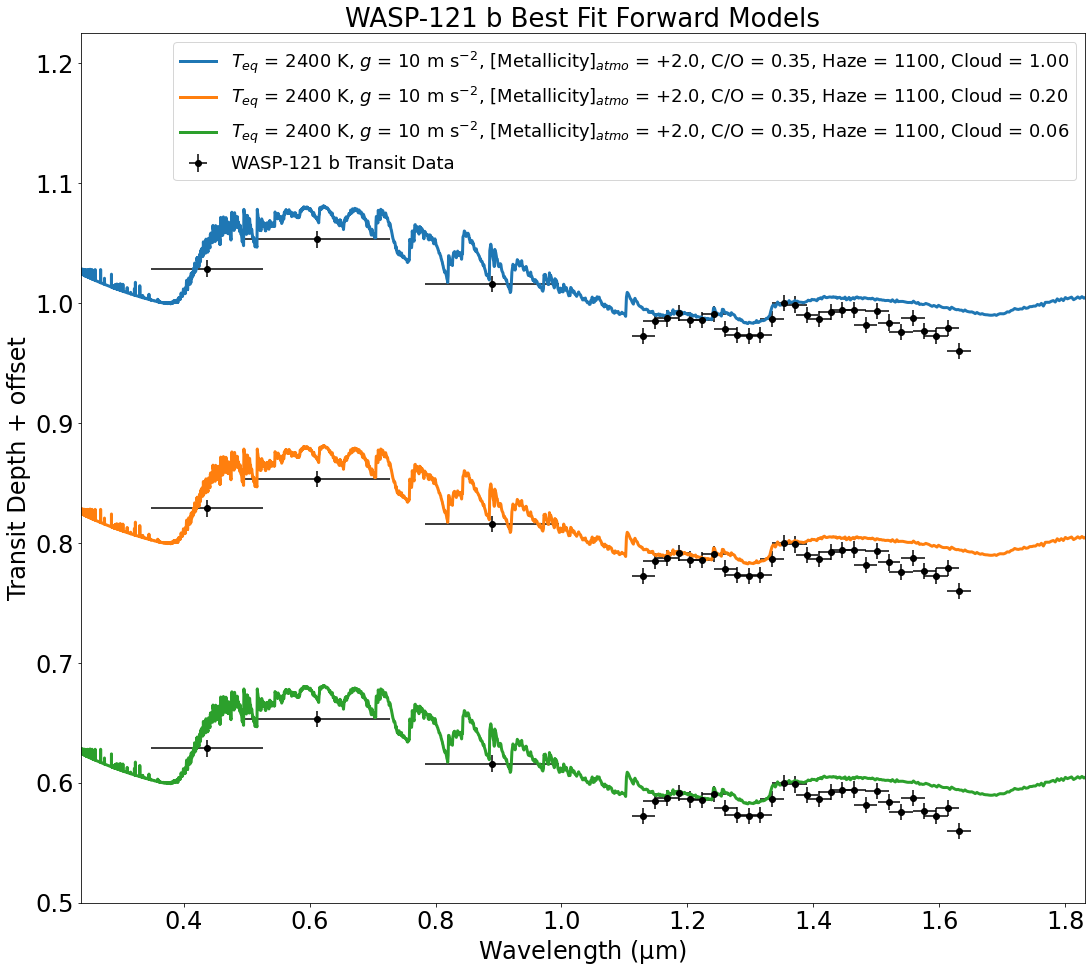

In [10]:
#Change the spacing between the three models in the plot below
spacer = 0.2

plt.figure(figsize=(18,16))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title(planet+' Best Fit Forward Models', fontsize=26)
plt.xlabel('Wavelength ($\mathrm{\mu}$m)',fontsize=24)
plt.ylabel('Transit Depth + offset',fontsize=24)

index = abs(model['wavelength'] - df.centralwavelng[ni]).idxmin()
print(index)
plt.plot(model.wavelength,model[min1]/model[min1][index], lw=3,
         label='$T_{eq}$ = '+min1[0:4].lstrip('0')+' K, $g$ = '
         +min1[5:7]+' m s$^{-2}$, [Metallicity]$_{atmo}$ = '
         +min1[8:12]+', C/O = '+min1[13:17]+', Haze = '
         +min1[18:22].lstrip('0')+', Cloud = '+min1[23:27])
plt.errorbar(x=dfsm.centralwavelng,y=dfsm.rprs2,xerr=dfsm.bandwidth,yerr=dfsm.rprs2_err,fmt='o',color='black', label=planet+' Transit Data')

plt.plot(model.wavelength,model[min2]/model[min2][index]-spacer, lw=3,
         label='$T_{eq}$ = '+min2[0:4].lstrip('0')+' K, $g$ = '
         +min2[5:7]+' m s$^{-2}$, [Metallicity]$_{atmo}$ = '
         +min2[8:12]+', C/O = '+min2[13:17]+', Haze = '
         +min2[18:22].lstrip('0')+', Cloud = '+min2[23:27])
plt.errorbar(x=dfsm.centralwavelng,y=dfsm.rprs2-spacer,xerr=dfsm.bandwidth,yerr=dfsm.rprs2_err,fmt='o',color='black')

plt.plot(model.wavelength,model[min3]/model[min3][index]-spacer*2, lw=3,
         label='$T_{eq}$ = '+min3[0:4].lstrip('0')+' K, $g$ = '
         +min3[5:7]+' m s$^{-2}$, [Metallicity]$_{atmo}$ = '
         +min3[8:12]+', C/O = '+min3[13:17]+', Haze = '
         +min3[18:22].lstrip('0')+', Cloud = '+min3[23:27])
plt.errorbar(x=dfsm.centralwavelng,y=dfsm.rprs2-spacer*2,xerr=dfsm.bandwidth,yerr=dfsm.rprs2_err,fmt='o',color='black')

plt.legend(loc='upper right', fontsize=18)
plt.xlim(np.min(dfsm.centralwavelng)-0.2,np.max(dfsm.centralwavelng)+0.2)
plt.ylim(0.5,1.225)
# plt.xscale('log') #uncomment if necessary
plt.savefig(planet+'_best_forward_models.png')

You have reached the end of this tutorial, congratulations!

#Development Roadmap

*   Add rainout condensation models from [Goyal et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.4503G/abstract). Currently, only local condensation models are implemented.
*   Add other model grids (e.g., [Fortney et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...709.1396F/abstract)).
*   Edit for easy user upload of their own data.
*   Edit to allow/convert different transit depth parameters (e.g., Rp/Rs, (Rp/Rs)^2, %, mmag).
*   Acquire transit data from community repositories (e.g., [Exoplanet Watch](https://exoplanets.nasa.gov/exoplanet-watch/about-exoplanet-watch/overview/)).
*   Color transit data by input source to allow checking for inconsistent data or removing sources.
*   Allow for combining/averaging measurements at the same wavelength/bandpass.
*   Use the forward models to generate synthetic spectrophotometry for future missions (e.g. JWST, ARIEL).